In [3]:
import pandas as pd
import numpy as np
from tqdm import tqdm
from optiland.optic import Optic
from optiland import analysis, wavefront

In [4]:
class CookeTriplet(Optic):
    def __init__(self):
        self.reset()

    def reset(self):
        Optic.__init__(self)  # reset full system

        self.add_surface(index=0, radius=np.inf, thickness=np.inf)
        self.add_surface(index=1, radius=22.01359, thickness=3.25896, material='SK16')
        self.add_surface(index=2, radius=-435.76044, thickness=6.00755)
        self.add_surface(index=3, radius=-22.21328, thickness=0.99997, material=('F2', 'schott'))
        self.add_surface(index=4, radius=20.29192, thickness=4.75041, is_stop=True)
        self.add_surface(index=5, radius=79.68360, thickness=2.95208, material='SK16')
        self.add_surface(index=6, radius=-18.39533, thickness=42.20778)
        self.add_surface(index=7)

        self.set_aperture(aperture_type='EPD', value=10)

        self.set_field_type(field_type='angle')
        self.add_field(y=0)
        self.add_field(y=14)
        self.add_field(y=20)

        self.add_wavelength(value=0.55, is_primary=True)

    def decenter(self, lens_idx, dx=0, dy=0, dz=0):
        for idx in [lens_idx*2+1, lens_idx*2+2]:
            surf = self.surface_group.surfaces[idx]  # get surface
            cs = surf.geometry.cs  # get coordinate system

            # move surface
            cs.x += dx
            cs.y += dy
            cs.z += dz

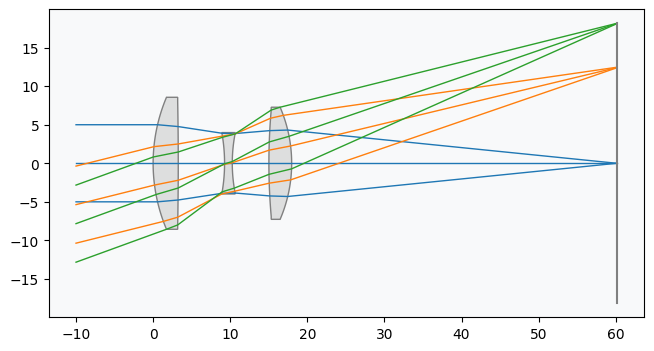

In [5]:
lens = CookeTriplet()
lens.draw()

In [6]:
np.random.seed(42)

num_samples = 1_000

delta = 0.5

dx1 = np.random.uniform(-delta, delta, num_samples)
dy1 = np.random.uniform(-delta, delta, num_samples)
dz1 = np.random.uniform(-delta, delta, num_samples)

dx2 = np.random.uniform(-delta, delta, num_samples)
dy2 = np.random.uniform(-delta, delta, num_samples)
dz2 = np.random.uniform(-delta, delta, num_samples)

dx3 = np.random.uniform(-delta, delta, num_samples)
dy3 = np.random.uniform(-delta, delta, num_samples)
dz3 = np.random.uniform(-delta, delta, num_samples)

df = pd.DataFrame({'dx1': dx1, 'dy1': dy1, 'dz1': dz1,
                   'dx2': dx2, 'dy2': dy2, 'dz2': dz2,
                   'dx3': dx3, 'dy3': dy3, 'dz3': dz3})

In [7]:
data = np.zeros((num_samples, 3, 36), dtype=np.float32)

for k, row in tqdm(df.iterrows(), total=num_samples):
    lens.reset()
    lens.decenter(0, row['dx1'], row['dy1'], row['dz1'])
    lens.decenter(1, row['dx2'], row['dy2'], row['dz2'])
    lens.decenter(2, row['dx3'], row['dy3'], row['dz3'])

    z1 = wavefront.ZernikeOPD(lens, field=(0, 0.0), wavelength=0.55, zernike_type='standard', num_terms=36)
    z2 = wavefront.ZernikeOPD(lens, field=(0, 0.7), wavelength=0.55, zernike_type='standard', num_terms=36)
    z3 = wavefront.ZernikeOPD(lens, field=(0, 1.0), wavelength=0.55, zernike_type='standard', num_terms=36)

    data[k, 0] = z1.coeffs
    data[k, 1] = z2.coeffs
    data[k, 2] = z3.coeffs

100%|██████████| 1000/1000 [18:36<00:00,  1.12s/it]


In [8]:
np.save('Cooke_triplet_wavefront_data.npy', data)

In [9]:
df.to_csv('Cooke_wavefront_data.csv', index=False)